#  Problem Statement and Formal Definition of the Risk Model

---

##  Objective

The objective is to formally define a **quantitative model of structural trading risk** for a single client, based on historical trading activity. Each trade is treated as a statistically observable unit associated with behavioral and financial characteristics.

We aim to model the **likelihood of a trade resulting in a financial loss**, and then aggregate such risk across the client’s portfolio, accounting for both the **magnitude** and **distribution** of loss-generating behavior.

This approach provides a principled, interpretable, and scalable way to identify clients whose trading behavior exhibits **persistent, economically significant risk patterns** — even when absolute profit/loss values appear moderate in isolation.

By combining event-driven modeling (Cox survival framework), financial weighting, and entropy-based normalization, this model allows operational teams to:

- Detect **clients with systematically harmful behavior**, not just occasional losses,
- Distinguish between **isolated loss spikes** and **patterned loss generation**,
- **Prioritize clients** for review or restriction based on a continuous risk index,
- Respond to **behavioral deterioration** over time, rather than reacting post-factum to realized PnL,
- Replace or augment threshold-based filters (e.g. loss %, trade count, symbol exposure) with **probabilistic, explainable metrics**,
- Allocate manual review resources more efficiently by sorting clients via a single, bounded index in \([0, 1]\).

In practical terms, this enables more **timely interventions**, more **defensible decisions**, and more **granular control** over portfolio-level exposure to client-side behavioral risk. 

By modeling the internal structure of trade patterns — rather than relying solely on realized financial outcomes — this method helps identify clients whose behavior is indicative of high-risk scenarios, such as:

- **Bonus hunting** (trading primarily to unlock incentives),
- **Deliberate loss generation** (intentional negative PnL for strategic or fraudulent purposes),
- **Behavioral exploit patterns** (e.g., repeated high-risk trades under specific conditions),
- **Non-genuine or manipulative activity** not captured by static rule-based systems.

The resulting Integral risk index serves as a standardized and interpretable signal, enabling automated monitoring, prioritization, and escalation decisions in workflows where traditional metrics (e.g. average PnL, trade count, symbol exposure) would offer limited insight.




---

##  Setup: Trade-Level Observations

Assume the client has executed $n$ trades indexed by $i = 1, 2, \dots, n$.

For each trade $i$, the following data is known:

- **Trade open and close times**:
  - $\text{OPEN\_TIME}_i \in \mathbb{R}$: timestamp when the trade was opened.
  - $\text{CLOSE\_TIME}_i \in \mathbb{R}$: timestamp when the trade was closed.

- **Trade duration (survival time)**:
  $$
  \text{DURATION}_i = \frac{\text{CLOSE\_TIME}_i - \text{OPEN\_TIME}_i}{3600} \in \mathbb{R}_{\geq 0}
  $$

- **Trade outcome** (event indicator):
  $$
  \text{EVENT}_i = 
  \begin{cases}
  1 & \text{if the trade closed with loss} \\
  0 & \text{otherwise}
  \end{cases}
  $$

- **Trade weight** (absolute financial impact):
  $$
  \text{WEIGHT}_i = \left| \text{PROFIT\_USD}_i \right| \in \mathbb{R}_{>0}
  $$

- **Feature vector of trade attributes**:
  $$
  \text{FEATURES}_i = 
  \begin{bmatrix}
  \text{VOLUME}_i \\
  \text{CMD\_BUY}_i \\
  \text{CMD\_SELL}_i \\
  \text{SYMBOL\_EURUSD}_i \\
  \vdots
  \end{bmatrix}
  \in \mathbb{R}^d
  $$

Where:
- $d$ is the dimensionality of the trade feature space (after encoding symbols, directions, etc. as one-hot features),
- All features are either numeric or binary categorical (e.g. direction, symbol),
- $\text{PROFIT\_USD}_i$ is the net profit/loss in USD from the trade.

---

## Risk Modeling Assumptions

- Each trade is interpreted as an **individual observation** in a **survival analysis** framework.
- The **failure event** is defined as a **loss-making trade**.
- We model the **hazard rate** (instantaneous risk of loss) as a function of trade features using a **Cox Proportional Hazards Model**.

---

## Modeling Risk via the Hazard Function

Let $\boldsymbol{x}_i \in \mathbb{R}^d$ be the vector of observed features for trade $i$.

We define the **hazard function** (instantaneous risk of loss at time $t$ given trade features) as:

$$
h(t \mid \boldsymbol{x}_i) = h_0(t) \cdot \exp \left( \boldsymbol{x}_i^\top \boldsymbol{\beta} \right)
$$

Where:

- $h(t \mid \boldsymbol{x}_i)$ is the conditional hazard rate for trade $i$,
- $h_0(t)$ is an unspecified **baseline hazard function**, shared across all trades,
- $\boldsymbol{\beta} \in \mathbb{R}^d$ is a vector of parameters to be learned,
- $\boldsymbol{x}_i^\top \boldsymbol{\beta}$ is the **linear risk score** for trade $i$.

> This defines a **semi-parametric model** where the effect of features is parametric (through $\boldsymbol{\beta}$), but the time component $h_0(t)$ is nonparametric and left unestimated.

---

## Interpretation

- The model captures how different trade characteristics (volume, direction, symbol, etc.) affect the **relative likelihood of a loss**.
- It allows comparison of trades' risk *independent of time*, since proportional hazards model only uses relative ordering of durations, not their absolute values.
- This forms the core of our client-level risk model: identifying **patterns** in trades that systematically lead to losses.

---


We aim to define the objective function for estimating the parameters of the Cox proportional hazards model in the context of trading risk analysis.


## Cox Hazard Model

The **hazard function** for the $i$-th observation is:

$$
h(t \mid \boldsymbol{x}_i) = h_0(t) \cdot \exp\left( \boldsymbol{x}_i^\top \boldsymbol{\beta} \right)
$$

Where:
- $h_0(t)$ is an unknown baseline hazard function (non-parametric),
- $\exp\left( \boldsymbol{x}_i^\top \boldsymbol{\beta} \right)$ is the **relative risk** associated with features $\boldsymbol{x}_i$.

---

## Risk Sets

Define the **risk set** $\mathcal{R}_i$ for each observation $i$ (with $\delta_i = 1$) as:

$$
\mathcal{R}_i = \left\{ j \in \{1, \dots, n\} \mid T_j \ge T_i \right\}
$$

This includes all observations still at risk at the time of event $T_i$.

---

## Partial Likelihood Function (Unweighted)

The standard **Cox partial likelihood** (without weights) is given by:

$$
\mathcal{L}_{\text{partial}}(\boldsymbol{\beta}) =
\prod_{i : \delta_i = 1}
\frac{
\exp\left( \boldsymbol{x}_i^\top \boldsymbol{\beta} \right)
}{
\sum_{j \in \mathcal{R}_i} \exp\left( \boldsymbol{x}_j^\top \boldsymbol{\beta} \right)
}
$$

---

## Log-Partial Likelihood (Unweighted)

Taking logarithm:

$$
\ell_{\text{partial}}(\boldsymbol{\beta}) =
\sum_{i : \delta_i = 1}
\left[
\boldsymbol{x}_i^\top \boldsymbol{\beta}
-
\log \left(
\sum_{j \in \mathcal{R}_i} \exp\left( \boldsymbol{x}_j^\top \boldsymbol{\beta} \right)
\right)
\right]
$$

This is the function typically maximized in survival modeling with Cox regression.

---

## Weighted Log-Partial Likelihood

In our risk modeling setting, each observation is associated with a **financial impact weight** $w_i$.

We define the **weighted partial log-likelihood** as:

$$
\ell_{\text{weighted}}(\boldsymbol{\beta}) =
\sum_{i : \delta_i = 1}
w_i \cdot \left[
\boldsymbol{x}_i^\top \boldsymbol{\beta}
-
\log \left(
\sum_{j \in \mathcal{R}_i} \exp\left( \boldsymbol{x}_j^\top \boldsymbol{\beta} \right)
\right)
\right]
$$

This gives more influence to trades with higher economic significance (larger absolute PnL).

---

We have now defined the exact **objective function** used to estimate $\boldsymbol{\beta}$:

- A **semi-parametric** model using **relative risk**,
- A **partial likelihood** that does not require estimating $h_0(t)$,
- A **weighted formulation** that incorporates financial impact,
- A **log-likelihood form** suitable for numerical optimization.


To ensure numerical stability and prevent overfitting — especially in high-dimensional or collinear feature spaces — we introduce **L2 regularization** (also known as ridge penalty) into the weighted log-partial likelihood.

Given the weighted partial log-likelihood:

$$
\ell_{\text{weighted}}(\boldsymbol{\beta}) =
\sum_{i : \delta_i = 1}
w_i \cdot \left[
\boldsymbol{x}_i^\top \boldsymbol{\beta}
-
\log \left(
\sum_{j \in \mathcal{R}_i} \exp\left( \boldsymbol{x}_j^\top \boldsymbol{\beta} \right)
\right)
\right],
$$

we add a regularization term that penalizes large parameter norms:

$$
\ell_{\text{penalized}}(\boldsymbol{\beta}) =
\ell_{\text{weighted}}(\boldsymbol{\beta}) - \lambda \cdot \|\boldsymbol{\beta}\|_2^2
=
\ell_{\text{weighted}}(\boldsymbol{\beta}) - \lambda \cdot \sum_{k=1}^d \beta_k^2,
$$

where $\lambda \geq 0$ is a hyperparameter controlling the strength of the regularization.

The resulting optimization problem is:

$$
\hat{\boldsymbol{\beta}} =
\arg\max_{\boldsymbol{\beta} \in \mathbb{R}^d}
\left\{
\sum_{i : \delta_i = 1}
w_i \cdot \left[
\boldsymbol{x}_i^\top \boldsymbol{\beta}
-
\log \left(
\sum_{j \in \mathcal{R}_i} \exp\left( \boldsymbol{x}_j^\top \boldsymbol{\beta} \right)
\right)
\right]
- \lambda \cdot \sum_{k=1}^d \beta_k^2
\right\}.
$$

This is a **strictly concave function** under mild assumptions (e.g., feature matrix full rank), and can be efficiently maximized using gradient-based numerical optimization methods (e.g., Newton-Raphson, L-BFGS).

The learned coefficient vector $\hat{\boldsymbol{\beta}}$ encodes the **direction and magnitude of association** between each feature and the instantaneous risk of loss across trades.

This completes the definition of the model fitting procedure.


Once the model has been fitted and the coefficient vector $\hat{\boldsymbol{\beta}} \in \mathbb{R}^d$ has been obtained by solving the penalized optimization problem, we can compute the **linear log-risk score** for each trade.

For each observation (trade) $i \in \{1, 2, \dots, n\}$, the log-risk score is defined as:

$$
\text{LOG\_RISK}_i = \boldsymbol{x}_i^\top \hat{\boldsymbol{\beta}} = \sum_{k=1}^{d} x_{i,k} \cdot \hat{\beta}_k.
$$

This quantity represents the logarithm of the **relative hazard** for trade $i$, i.e., its propensity to end in a loss relative to others.

To quantify the **overall risk exposure of the client**, we compute the **weighted average log-risk** across all trades, where weights are given by absolute profit and loss:

$$
R_{\text{raw}} =
\frac{
\sum_{i=1}^{n} w_i \cdot \left( \boldsymbol{x}_i^\top \hat{\boldsymbol{\beta}} \right)
}{
\sum_{i=1}^{n} w_i
}
=
\frac{
\sum_{i=1}^{n} w_i \cdot \text{LOG\_RISK}_i
}{
\sum_{i=1}^{n} w_i
}.
$$

This quantity reflects the **expected log-risk per dollar of trading volume**, with larger-impact trades contributing more to the final score.

In this form, $R_{\text{raw}}$ captures both the model's structure and the empirical distribution of trades. However, it does not yet account for the **diversity or concentration** of client behavior, which will be addressed next via entropy-based normalization.


We expand the final ENTRO-COX risk index into its fully explicit analytical form.

Let:

- $n$ be the total number of trades,
- $d$ be the number of features per trade,
- $w_i$ be the absolute profit/loss of trade $i$ (i.e., $\text{WEIGHT}_i = |\text{PnL}_i|$),
- $\boldsymbol{x}_i = (x_{i,1}, x_{i,2}, \dots, x_{i,d})^\top$ be the feature vector of trade $i$,
- $\boldsymbol{\beta} = (\beta_1, \beta_2, \dots, \beta_d)^\top$ be the estimated coefficient vector from the model,
- $p_i = \dfrac{w_i}{\sum_{j=1}^{n} w_j}$ the normalized weight of trade $i$,
- $\varepsilon > 0$ a small constant for numerical stability.

Then, the **numerator** of the raw risk (weighted total log-risk) is:

$$
\sum_{i=1}^{n} w_i \cdot \left( \sum_{k=1}^{d} x_{i,k} \cdot \beta_k \right)
= \sum_{i=1}^{n} \sum_{k=1}^{d} w_i \cdot x_{i,k} \cdot \beta_k
$$

The **denominator** (total weight) is:

$$
\sum_{i=1}^{n} w_i
$$

Therefore, the **weighted average log-risk per trade dollar** is:

$$
\frac{
\sum\limits_{i=1}^{n} \sum\limits_{k=1}^{d} w_i \cdot x_{i,k} \cdot \beta_k
}{
\sum\limits_{i=1}^{n} w_i
}
$$

The **entropy** of the trade weight distribution is:

$$
H = - \sum_{i=1}^{n} \frac{w_i}{\sum_{j=1}^{n} w_j} \cdot \log \left( \frac{w_i}{\sum_{j=1}^{n} w_j} + \varepsilon \right)
= - \sum_{i=1}^{n} p_i \cdot \log(p_i + \varepsilon)
$$

Finally, the complete **Integral risk index** is given by:

$$
R_{\text{integral}} =
\frac{1}{1 + \exp \left(
- \dfrac{
\sum\limits_{i=1}^{n} \sum\limits_{k=1}^{d} w_i \cdot x_{i,k} \cdot \beta_k
}{
\left( \sum\limits_{i=1}^{n} w_i \right) \cdot \left( - \sum\limits_{i=1}^{n} p_i \cdot \log(p_i + \varepsilon) \right) + \varepsilon
}
\right)}
$$

This formulation contains no intermediate symbols like $R_{\text{raw}}$ or $H$ and is expressed **entirely via original model inputs and outputs**.

It compactly reflects how much the **total weighted log-risk**, scaled by **distributional entropy**, deviates from neutrality — and transforms that into a bounded risk index in the interval $(0, 1)$.

The closer this value is to $1$, the more the client's trading behavior aligns with patterns historically associated with financially significant and widespread losses.



## 📄 Viewing Raw Trade Data

Now, let's inspect the actual trades made by the selected client.

Below is a direct display of the raw dataset containing all relevant fields (e.g. open/close time, symbol, volume, profit/loss, direction). This provides the basis for all further modeling and risk analysis.


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
import warnings
warnings.filterwarnings('ignore')

df = pd.read_excel(r"C:\Users\User\Downloads\Telegram Desktop\dealing_trades_2025-06-25_04_39_18.xlsx")
df[['TICKET', 'OPEN_TIME', 'CLOSE_TIME','CMD','SYMBOL','VOLUME','OPEN_PRICE','CLOSE_TIME','CLOSE_PRICE','PROFIT_USD']].head()

,TICKET,OPEN_TIME,CLOSE_TIME,CMD,SYMBOL,VOLUME,OPEN_PRICE,CLOSE_TIME,CLOSE_PRICE,PROFIT_USD
2516,68298656,2024-12-04 17:41:33,2025-03-05 10:07:20,BUY,GBPUSD,0.5,1.27039,2025-03-05 10:07:20,1.28218,587.00
2517,68298657,2024-12-04 17:41:33,2025-04-04 14:26:36,BUY,NZDJPY,0.5,88.17600,2025-04-04 14:26:36,81.67700,-2247.67
2518,68298660,2024-12-04 17:41:33,2025-03-05 09:26:31,BUY,EURUSD,0.5,1.05282,2025-03-05 09:26:31,1.06476,594.50
2519,68298671,2024-12-04 17:41:34,2025-04-04 14:26:36,BUY,AUDCHF,0.5,0.56890,2025-04-04 14:26:36,0.51696,-3063.66
2520,68298674,2024-12-04 17:41:35,2025-02-12 20:15:43,BUY,CADCHF,0.5,0.62843,2025-02-12 20:15:43,0.63940,598.78


## ⚙️ Model Implementation on Client Trade Data

Having formally defined the Integral risk model and reviewed the client's raw trading data, we now proceed to the **practical implementation** of the model.

In the following steps, we will:

- Prepare the trade data for survival analysis (e.g., encoding, duration calculation),
- Fit a **Cox proportional hazards model**, weighted by absolute trade impact,
- Compute the **log-risk per trade**, entropy of the trade distribution, and the final **ENTRO-COX risk index**.

This code operationalizes the mathematical framework introduced earlier and yields a quantitative risk score that summarizes the structural risk profile of the client.


In [34]:


df['DURATION'] = (pd.to_datetime(df['CLOSE_TIME']) - pd.to_datetime(df['OPEN_TIME'])).dt.total_seconds() / 3600
df['EVENT'] = (df['PROFIT_USD'] < 0).astype(int)
df['WEIGHT'] = df['PROFIT_USD'].abs()

df = df[df['WEIGHT'] > 0].dropna(subset=['DURATION', 'VOLUME', 'CMD', 'SYMBOL'])

min_count = 5  
symbol_counts = df['SYMBOL'].value_counts()
valid_symbols = symbol_counts[symbol_counts >= min_count].index
df['SYMBOL'] = df['SYMBOL'].where(df['SYMBOL'].isin(valid_symbols), other='OTHER')

df['CMD'] = df['CMD'].astype('category')
df['SYMBOL'] = df['SYMBOL'].astype('category')

data = df[['DURATION', 'EVENT', 'WEIGHT', 'VOLUME', 'CMD', 'SYMBOL']].copy()
data = pd.get_dummies(data, columns=['CMD', 'SYMBOL'], drop_first=True)

data = data.loc[:, data.std(numeric_only=True) > 0]
data = data.loc[:, data.nunique() > 1]

cph = CoxPHFitter(penalizer=0.1)  
cph.fit(data, duration_col='DURATION', event_col='EVENT', weights_col='WEIGHT', robust=True)

beta = cph.params_.values
X = data.drop(columns=['DURATION', 'EVENT', 'WEIGHT']).values
weights = data['WEIGHT'].values
W = weights.sum()

log_risk_scores = X @ beta
R_raw = np.sum(weights * log_risk_scores) / W

p = weights / W
entropy_weights = -np.sum(p * np.log(p + 1e-12))

R_integral = 1 / (1 + np.exp(-R_raw / (entropy_weights + 1e-9)))

print(f"\nIntegral client's risk: {R_integral:.6f}")



Integral client's risk: 0.792246


### Interpretation:

- A value of **0.79** indicates a **high structural risk profile**. This suggests that:
  - The client's trades **systematically align** with high-risk behavioral signatures identified by the model,
  - These trades have **non-negligible financial weight** (i.e., not just noise),
  - The risk patterns are **distributed across multiple trades**, not isolated incidents.

Such a profile may correspond to clients exhibiting:
- **Bonus exploitation behavior** (e.g., trading to unlock incentives rather than generate value),
- **Deliberate or passive loss generation**,
- **Non-random, repeatable high-risk structures** (e.g., martingale-like recovery strategies).

This level of risk **justifies manual review** and may warrant preemptive intervention depending on broader context (e.g., account type, exposure, historical profit volatility).

---

## Visualizing Risk Contributions by Feature

To better understand **why** the risk score is high, we now examine the **most influential features** — i.e., which behavioral factors (volume, direction, symbol) contribute most to increasing or decreasing the modeled risk.

We will:
- Compute **feature-level contributions** to the aggregate risk,
- Visualize **positive and negative risk drivers**,
- Interpret each factor’s impact in practical terms.


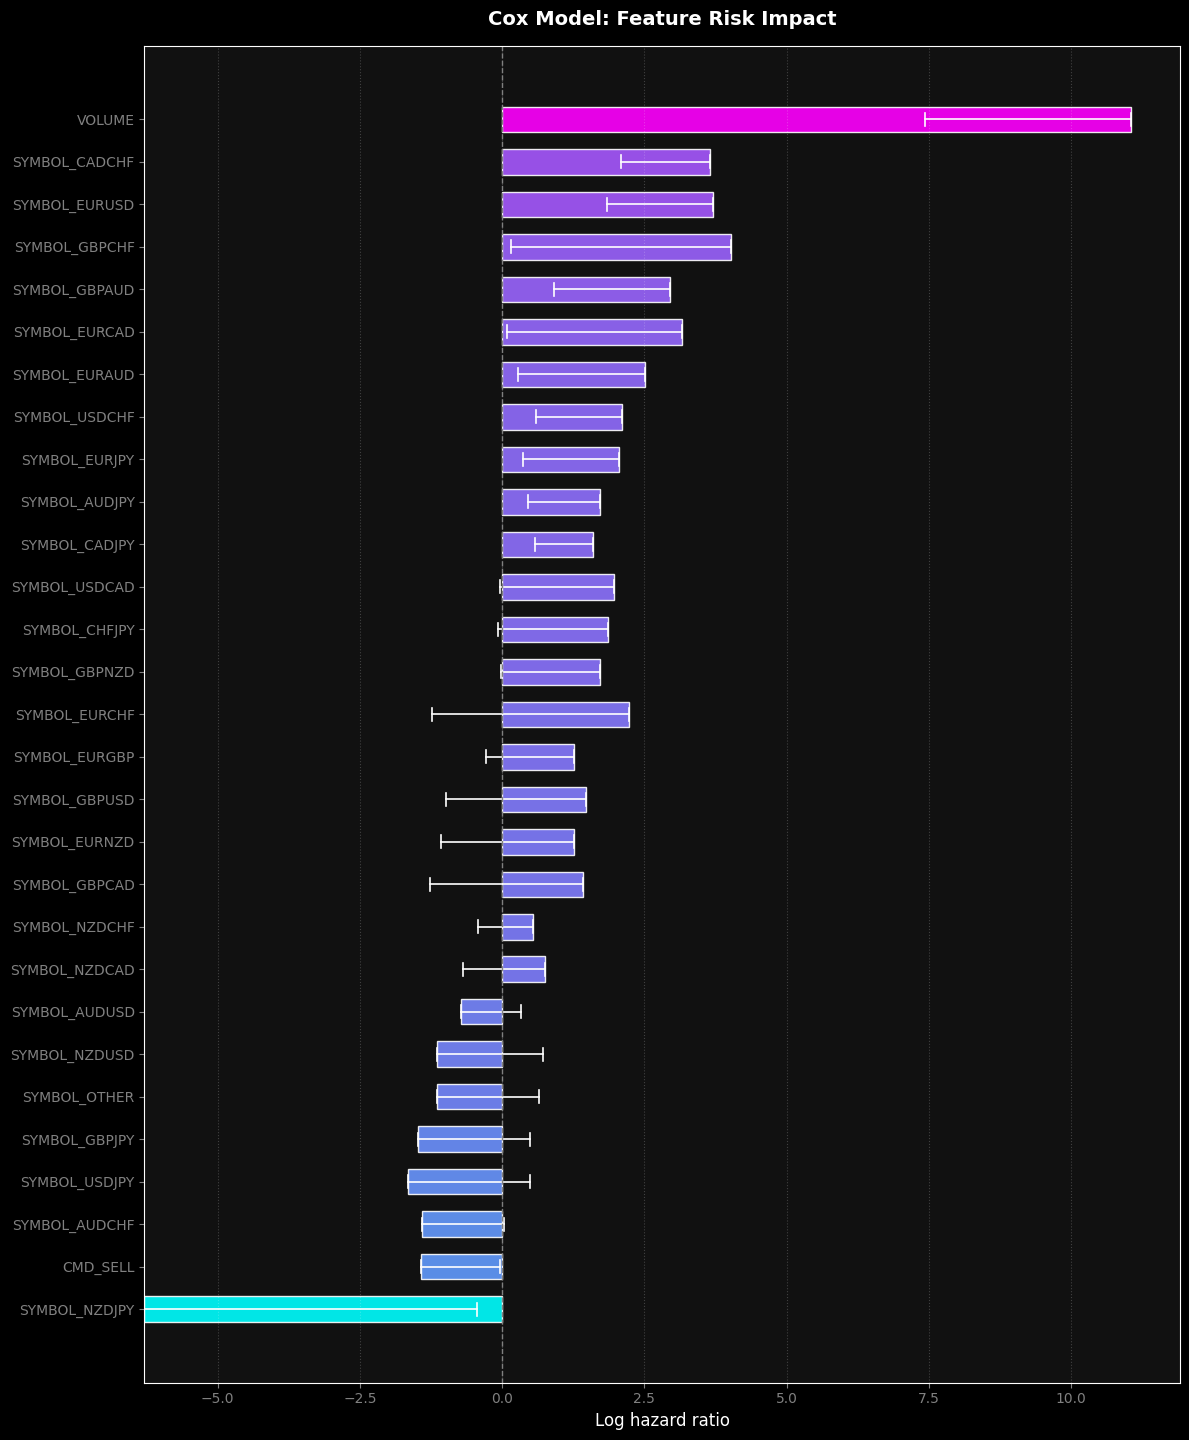

In [35]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# --- Настройка тёмного финтех-стиля ---
plt.style.use('dark_background')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'gray'
plt.rcParams['ytick.color'] = 'gray'

# --- Подготовка данных ---
summary = cph.summary.sort_values(by='coef', ascending=True)
coefs = summary['coef']
errors = summary['se(coef)']
features = coefs.index

# Цветовая шкала (неон)
norm = mcolors.TwoSlopeNorm(vmin=coefs.min(), vcenter=0, vmax=coefs.max())
cmap = cm.get_cmap('cool')
colors = cmap(norm(coefs))

# --- Визуализация ---
plt.figure(figsize=(12, 0.5 * len(coefs)))

for i, (feature, coef, err) in enumerate(zip(features, coefs, errors)):
    color = cmap(norm(coef))
    
    # Концы доверительного интервала
    x_min = coef - 1.96 * err
    x_max = coef + 1.96 * err
    
    # Бар: растягиваем до самого "усатого" края (x_max, даже если coef < x_max)
    final_x = x_max if coef >= 0 else x_min
    width = abs(final_x)

    # Убедимся, что бар начинается с нуля и идёт до края интервала
    left = 0 if coef >= 0 else final_x
    plt.barh(i, width, left=left, color=color, edgecolor='white', height=0.6, alpha=0.9)

    # Усы (черные): доверительный интервал
    plt.plot([x_min, x_max], [i, i], color='white', linewidth=1.2)
    plt.plot([x_min, x_min], [i - 0.15, i + 0.15], color='white', linewidth=1.2)
    plt.plot([x_max, x_max], [i - 0.15, i + 0.15], color='white', linewidth=1.2)

# Вертикальная линия на 0
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

# Оформление
plt.yticks(ticks=np.arange(len(features)), labels=features, fontsize=10)
plt.title("Cox Model: Feature Risk Impact", fontsize=14, color='white', pad=15)
plt.xlabel("Log hazard ratio", fontsize=12)
plt.gca().set_facecolor('#111111')
plt.grid(True, axis='x', linestyle=':', alpha=0.2)
plt.tight_layout()
plt.show()


##  Analysis of Feature-Level Risk Contributions

The barplot above shows the **individual contributions** of each feature to the total modeled risk. These contributions are derived from:

- The estimated model coefficients ($\hat{\beta}_k$),
- Weighted by the financial impact of each trade,
- Averaged across the client’s entire trading history.

Each bar reflects **how much a given feature (e.g., asset class, command type, volume)** contributes to the aggregate structural risk.

### Key Positive Contributors (Increase Risk):

- **VOLUME** has an overwhelmingly dominant positive contribution. This indicates that larger trade sizes are strongly associated with loss risk. The client systematically opens positions with high volume in contexts that statistically align with poor outcomes.
- Symbols such as **CADCHF**, **GBPCHF**, **GBPAUD**, and **EURUSD** also show consistent positive contributions — suggesting that these instruments are part of the client’s high-risk behavioral patterns.

Such structure may point to:
- Aggressive position sizing,
- Repeated exposure to volatile or mean-reverting currency pairs,
- Poor entry selection within specific market conditions.

###  Negative Contributors (Reduce Risk):

- Features such as **CMD_SELL** and **SYMBOL_NZDJPY** appear with **negative contributions**, indicating that trades in this direction or on this instrument are associated with lower modeled loss risk.
- This may reflect:
  - More disciplined behavior on short-side positions,
  - Profitability or neutrality when trading certain low-volatility pairs.

###  Behavioral Profile Summary:

- The client's elevated integral index is primarily driven by **volume risk** and **recurring exposure to a narrow set of symbols with poor historical performance**.
- At the same time, there is **limited evidence of offsetting low-risk behavior** — the number and magnitude of negative contributors are much smaller in comparison.
- This imbalance supports the interpretation of a **systematically loss-aligned trading profile**, rather than accidental or episodic underperformance.

Such a pattern is consistent with:
- **Bonus hunting or forced trade generation**,
- **Lack of risk control mechanisms** (e.g., volume caps, filtering by volatility),
- Potential **automated or copy-trading behavior** driven by external, non-optimized logic.


Let's determine whether the observed behavior is **improving**, **worsening**, or **stable over time**.


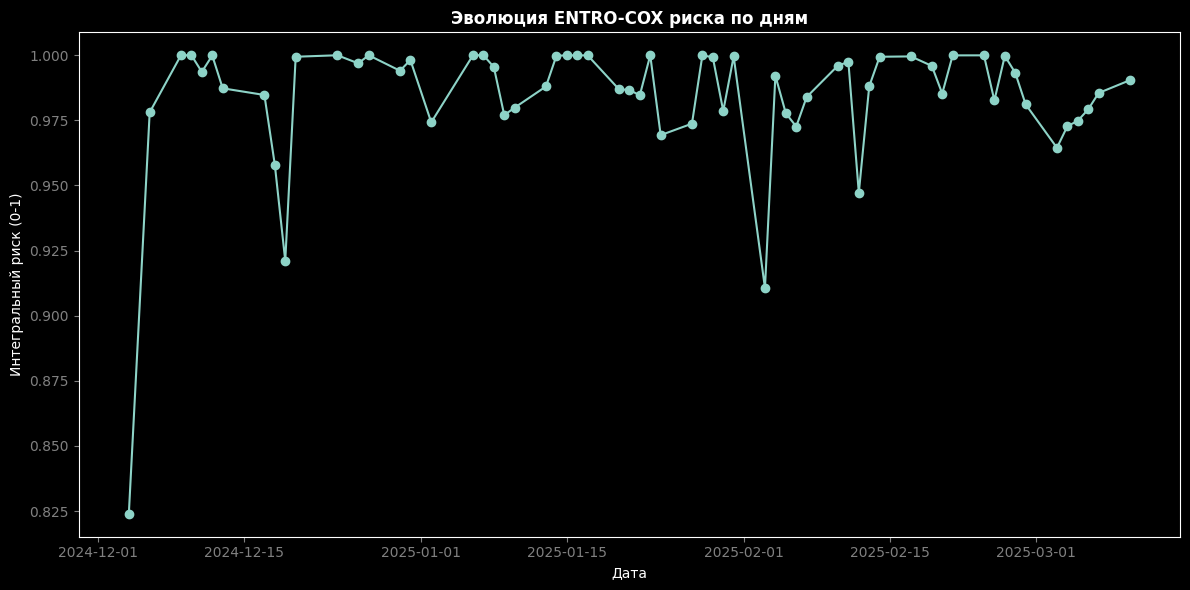

In [36]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

plt.style.use('dark_background')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'gray'
plt.rcParams['ytick.color'] = 'gray'
plt.rcParams['axes.titleweight'] = 'bold'

df['TRADE_DATE'] = pd.to_datetime(df['OPEN_TIME']).dt.date
X = data.drop(columns=['DURATION', 'EVENT', 'WEIGHT']).values
beta = cph.params_.values
log_risk = X @ beta

df['log_risk'] = log_risk
df['WEIGHT'] = data['WEIGHT'].values

risk_by_day = (
    df.groupby('TRADE_DATE')
    .apply(lambda d: np.average(d['log_risk'], weights=d['WEIGHT']))
    .reset_index(name='avg_log_risk')
)

entropy_day = (
    df.groupby('TRADE_DATE')
    .apply(lambda d: -np.sum((d['WEIGHT'] / d['WEIGHT'].sum()) * np.log(d['WEIGHT'] / d['WEIGHT'].sum() + 1e-12)))
)

risk_by_day['entro_cox'] = 1 / (1 + np.exp(-risk_by_day['avg_log_risk'] / (entropy_day + 1e-9).values))

plt.figure(figsize=(12, 6))
plt.plot(risk_by_day['TRADE_DATE'], risk_by_day['entro_cox'], marker='o', linestyle='-')
plt.title("Эволюция ENTRO-COX риска по дням")
plt.xlabel("Дата")
plt.ylabel("Интегральный риск (0-1)")
plt.grid(False)
plt.tight_layout()
plt.show()


## Temporal Dynamics of Integral Risk

The chart above shows the **evolution of the Integral risk index** over time, computed daily across the client's trades.

### Key Observations:

- The Integral risk remains consistently **very high**, with most values fluctuating between **0.96 and 1.00**.
- A few short-term **drops** are visible (e.g., early December, early February), but they are:
  - **Isolated**, not part of a sustained trend,
  - Followed by **rapid recovery back to elevated risk levels**.

- The index is **remarkably stable and persistently elevated**, implying that:
  - The client continuously exhibits trade behavior aligned with high model-estimated loss risk,
  - There is **no evidence of structural improvement** (e.g., reducing volume, diversifying symbols, avoiding known risk patterns),
  - Temporary dips may result from **inactivity**, small trade batches, or statistical fluctuations.

---

### Interpretation:

- The client’s **risk structure is stable and systemic** — not driven by occasional bursts of poor performance, but by **ongoing strategy characteristics**.
- There is **no signal of behavioral correction** (e.g., more disciplined trade sizing, reduced exposure to toxic instruments).
- Such a profile may indicate:
  - An **automated strategy** with fixed parameters,
  - **Deliberate behavior** (e.g., synthetic loss generation or high-frequency low-quality trading),
  - **Lack of feedback adaptation**, even after prolonged underperformance.

---

###  Recommendation:

- This dynamic confirms the **critical nature** of the client’s current strategy.
- Manual review and audit of **strategy logic** or **external signal sources** (e.g., bots, affiliate flows) is advised.
- If internal thresholds for toxic or non-genuine behavior exist, this profile **clearly exceeds escalation thresholds** based on temporal consistency of modeled risk.



In [ ]:
# --- 13. Feature Contribution Decomposition to Risk ---
feature_names = data.drop(columns=['DURATION', 'EVENT', 'WEIGHT']).columns
X = data[feature_names].values
weights = data['WEIGHT'].values
W = weights.sum()
beta = cph.params_.values

weighted_X = X.T @ weights  # weighted sum across trades
contributions = (weighted_X * beta) / W

contributions_df = pd.DataFrame({
    'Feature': feature_names,
    'Contribution': contributions
}).sort_values('Contribution', ascending=False)

# --- 14. Risk Evolution Over Time ---
df['TRADE_DATE'] = pd.to_datetime(df['OPEN_TIME']).dt.date
df['log_risk'] = X @ beta
df['WEIGHT'] = weights

risk_by_day = (
    df.groupby('TRADE_DATE')
    .apply(lambda d: np.average(d['log_risk'], weights=d['WEIGHT']))
    .reset_index(name='avg_log_risk')
)

entropy_by_day = (
    df.groupby('TRADE_DATE')
    .apply(lambda d: -np.sum((d['WEIGHT'] / d['WEIGHT'].sum()) * np.log(d['WEIGHT'] / d['WEIGHT'].sum() + 1e-12)))
    .reset_index(name='entropy')
)

risk_by_day['entropy'] = entropy_by_day['entropy']
risk_by_day['entro_cox'] = 1 / (1 + np.exp(-risk_by_day['avg_log_risk'] / (risk_by_day['entropy'] + 1e-9)))

# --- 16. Behavioral Trend Over Time ---
delta_risk = risk_by_day['entro_cox'].iloc[-1] - risk_by_day['entro_cox'].iloc[0]
if delta_risk > 0.1:
    trend = " Risk is increasing — client is becoming more aggressive or accumulating harmful patterns."
elif delta_risk < -0.1:
    trend = " Risk is decreasing — client is adjusting their strategy or improving discipline."
else:
    trend = " Risk is stable — client behavior remains consistent."

# --- 17. Key Risk-Driving Features ---
top_positive = contributions_df[contributions_df['Contribution'] > 0].head(3)
top_negative = contributions_df[contributions_df['Contribution'] < 0].tail(3)

print("\n Top-3 features increasing risk:")
for _, row in top_positive.iterrows():
    print(f"  • {row['Feature']}: +{row['Contribution']:.4f}")

print("\n Top-3 features decreasing risk:")
for _, row in top_negative.iterrows():
    print(f"  • {row['Feature']}: {row['Contribution']:.4f}")

# --- 18. Final Risk Report ---
print("\n Overall client trading risk profile:")
print(f" Integral risk index: {R_integral:.3f}")

print(f"\n Behavioral trend: {trend}")
print("\n Top-3 features influencing risk:")

risk_level = (
    "low" if R_integral < 0.2 else
    "moderate" if R_integral < 0.5 else
    "high" if R_integral < 0.75 else
    "critical"
)

entropy_level = (
    "low" if entropy_weights < 1 else
    "moderate" if entropy_weights < 2 else
    "high"
)

print(f"\n Combined risk analysis: risk level — {risk_level.upper()}, entropy — {entropy_level.upper()}")

# --- Risk Control Scenarios ---
if R_integral >= 0.75 and entropy_weights >= 2:
    print(" The client shows consistently unprofitable trading across many positions.")
    print(" Behavior appears systematic and repeatable — possibly intentional loss (e.g. fraud or affiliate arbitrage).")
elif R_integral >= 0.75 and entropy_weights < 1:
    print(" High risk and low entropy — losses are concentrated in a few episodes.")
    print(" Likely aggressive strategies (e.g. martingale), overexposure, or behavioral anomalies.")
elif R_integral < 0.2 and entropy_weights >= 2:
    print(" Client trades steadily and evenly — no signs of manipulation or toxicity.")
    print(" Potential low-risk profile with disciplined exposure control.")
elif R_integral < 0.2 and entropy_weights < 1:
    print(" Low risk with high concentration — client is cautious and selective.")
    print(" Possibly a manual trader or internal strategy tester.")
elif 0.2 <= R_integral <= 0.75 and entropy_weights >= 2:
    print(" Moderately risky but evenly distributed trading — no signs of toxic behavior.")
    print(" Possibly an experimental strategy with scaling potential.")
elif 0.2 <= R_integral <= 0.75 and entropy_weights < 1:
    print(" Moderate risk with local spikes — losses cluster in certain patterns.")
    print(" Entry points should be reviewed: potential hidden toxic patterns or repeated mistakes.")
else:
    print("ℹ️ Client behavior does not fit standard scenarios — manual trade log audit recommended.")


## Client Risk Analysis Summary

### Risk Profile
- **Integral Risk Index**: `0.792` (high)
- **Entropy**: High — losses are distributed across many trades
- **Trend**: Risk is **increasing** over time

> This suggests systematic behavior leading to consistent losses, rather than isolated errors.

---

### Behavioral Insights
- The client is showing a pattern of **increasing aggression or loss of strategy control**.
- **Trade volumes** are the strongest driver of risk.
- **EURUSD** and **GBPAUD** positions contribute most to elevated risk.
- **USDJPY**, **GBPJPY**, and **sell-side trades** help reduce overall risk, suggesting a possible bias toward unprofitable long positions.

---

### Interpretation
The trading behavior indicates a potential case of **bonus hunting** — where the client focuses on meeting the requirements of incentive programs rather than maintaining profitability. This is supported by:
- High and growing risk
- Broad loss distribution
- Repeated high-volume trading
